# 1D implementation

(3145728, 3)


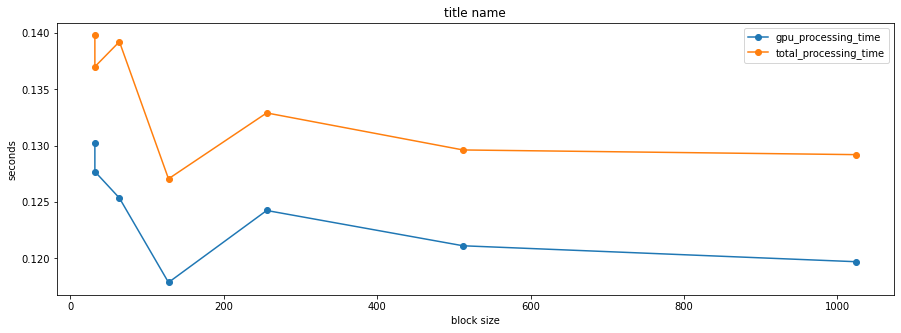

In [ ]:
# import os
# os.environ["NUMBA_ENABLE_CUDASIM"] = "0" 
# os.environ["NUMBA_CUDA_DEBUGINFO"] = "0"
import numba
from numba import cuda
import cv2
import matplotlib
import numpy as np
import time
import matplotlib.pyplot as plt

img = matplotlib.image.imread('test.jpg')
# img = img[::5, ::5]
image = (img[:, :, :3] ).astype('uint8')


imageWidth = image.shape[1]
imageHeight= image.shape[0]
image = image.reshape(imageWidth*imageHeight,3)
print(image.shape)
pixelCount = imageWidth * imageHeight

total_processing_time =[]
gpu_processing_time = []

blockSize_list = [32, 32, 64, 128, 256, 512, 1024]





for idx, blockSize in enumerate(blockSize_list):

  gridSize = int(pixelCount / blockSize)
  image = image.copy()
  start = time.time()
  devData = cuda.to_device(image)
  devOutput = cuda.device_array(
                              (imageHeight*imageWidth, 3),
                              np.uint8)
  @cuda.jit
  def grayscale(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

  gpu_start = time.time()
  grayscale[gridSize, blockSize](devData, devOutput)
  gpu_end = time.time()

  hostOutput = devOutput.copy_to_host()
  hostOutput = hostOutput.reshape((imageHeight, imageWidth,3)).astype('uint8')
  end = time.time()

  # if idx > 0:
  total_processing_time.append(end - start)
  gpu_processing_time.append(gpu_end - gpu_start)



x_axis = blockSize_list
y_axis_1 = gpu_processing_time
y_axis_2 = total_processing_time

plt.figure(figsize=(15,5))
plt.plot(x_axis, y_axis_1, label ='gpu_processing_time', marker='o')
plt.plot(x_axis, y_axis_2, label ='total_processing_time', marker='o')
plt.title('title name')
plt.xlabel('block size')
plt.legend()

plt.ylabel('seconds')
plt.show()

# 2D implementation

(2048, 1536, 3)
[0.13435673713684082, 0.00565028190612793, 0.010291814804077148, 0.004870891571044922, 0.004821062088012695, 0.005391597747802734]
[0.1281135082244873, 0.00014328956604003906, 0.00015401840209960938, 0.00013494491577148438, 0.00012445449829101562, 0.00011515617370605469]


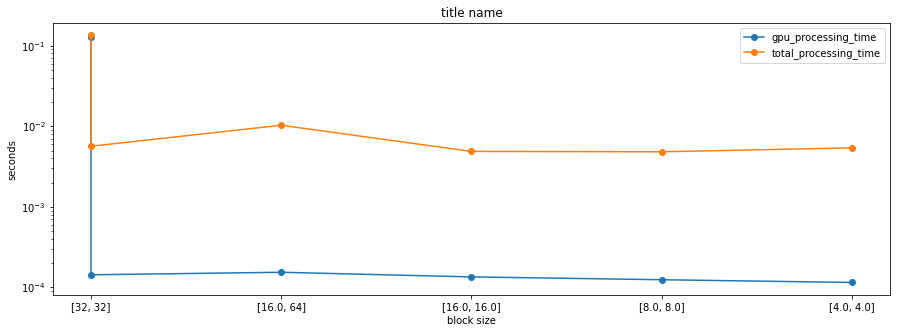

In [39]:
# import os
# os.environ["NUMBA_ENABLE_CUDASIM"] = "0" 
# os.environ["NUMBA_CUDA_DEBUGINFO"] = "0"
import numba
from numba import cuda
import cv2
import matplotlib
import numpy as np
import time

img = matplotlib.image.imread('test.jpg')
# img = img[::5, ::5]
image = (img[:, :, :3] ).astype('uint8')


imageWidth = image.shape[1]
imageHeight= image.shape[0]
# image = image.reshape(imageWidth*imageHeight,3)
print(image.shape)
pixelCount = imageWidth * imageHeight


# @cuda.jit
# def grayscale(src, dst):
#   tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#   g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
#   dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

@cuda.jit
def grayscale(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  g = np.uint8((src[tidy, tidx, 0] +src[tidy, tidx, 1] + src[tidy, tidx, 2])/3)
  dst[tidy, tidx] = g


total_processing_time =[]
gpu_processing_time = []


blockSize_list = [[1,1], [1,1], [0.5, 2], [0.5,0.5], [0.25,0.25], [0.125,0.125]]
blockSize_list_label = [str([1*32,1*32]), str([1*32,1*32]), str([0.5*32, 2*32]), str([0.5*32,0.5*32]), str([0.25*32,0.25*32]), str([0.125*32,0.125*32])]

for idx, warp_ratio in enumerate(blockSize_list):
  warp_no_w = warp_ratio[0]
  warp_no_h = warp_ratio[1]
  ratio_w = int(imageWidth/(32*warp_no_w))
  ratio_h = int(imageHeight/(32*warp_no_h))

  gridSize = (ratio_w, ratio_h)
  blockSize = (int(32*warp_no_w), int(32*warp_no_h)) #max thread/block = 1024

  image = image.copy()
  start = time.time()
  devData = cuda.to_device(image)

  devOutput = cuda.device_array(
                              (imageHeight, imageWidth, 3),
                              np.uint8)

  gpu_start = time.time()
  grayscale[gridSize, blockSize](devData, devOutput)
  gpu_end = time.time()

  hostOutput = devOutput.copy_to_host()
  # hostOutput = hostOutput.reshape((imageHeight, imageWidth,3)).astype('uint8')
  end = time.time()

  # if idx > 0:
  total_processing_time.append(end - start)
  gpu_processing_time.append(gpu_end - gpu_start)


print (total_processing_time)
print (gpu_processing_time)
x_axis = blockSize_list_label
y_axis_1 = gpu_processing_time
y_axis_2 = total_processing_time

plt.figure(figsize=(15,5))
plt.yscale('log')
plt.plot(x_axis, y_axis_1, label ='gpu_processing_time', marker='o')

plt.plot(x_axis, y_axis_2, label ='total_processing_time', marker='o')
plt.title('title name')
plt.xlabel('block size')
plt.legend()

plt.ylabel('seconds')
plt.show()